In [331]:
import pandas as pd
import matplotlib.pyplot as plt

# Visualizing Time Series in Pandas Demo

In [332]:
!wget --no-verbose https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/CalIt2.data;
!wget --no-verbose https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/CalIt2.events;
!wget --no-verbose https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/CalIt2.names;

2020-08-11 10:52:25 URL:https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/CalIt2.data [223402/223402] -> "CalIt2.data.7" [1]
2020-08-11 10:52:25 URL:https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/CalIt2.events [1142/1142] -> "CalIt2.events.6" [1]
2020-08-11 10:52:26 URL:https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/CalIt2.names [1701/1701] -> "CalIt2.names.5" [1]


## Dataset

https://archive.ics.uci.edu/ml/datasets/CalIt2+Building+People+Counts


**Raw Data**

In [337]:
pd.read_csv('CalIt2.data', header=None, names=['Flow', 'Date', 'Time', 'Count'])

,Flow,Date,Time,Count
0,7,07/24/05,00:00:00,0
1,9,07/24/05,00:00:00,0
2,7,07/24/05,00:30:00,1
3,9,07/24/05,00:30:00,0
4,7,07/24/05,01:00:00,0
...,...,...,...,...
10075,9,11/05/05,22:30:00,0
10076,7,11/05/05,23:00:00,0
10077,9,11/05/05,23:00:00,0
10078,7,11/05/05,23:30:00,1


### Process Data

In [338]:
def load_data(filepath):
    df = pd.read_csv('CalIt2.data', header=None, names=['Flow', 'Date', 'Time', 'Count'])
    
    # Process times
    df['Timestamp'] = df['Date'] + ' ' + df['Time']
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    df['Date'] = df['Timestamp'].dt.date
    df['Time'] = df['Timestamp'].dt.time
    
    
    # Process Flow Column
    df.loc[df['Flow']==7, 'Flow'] = 'Out'
    df.loc[df['Flow']==9, 'Flow'] = 'In'
    
    df = df.set_index('Timestamp')
    return df
    

df = load_data('CalIt2.data')

In [339]:
df.head()

,Flow,Date,Time,Count
Timestamp,,,,
2005-07-24 00:00:00,Out,2005-07-24,00:00:00,0
2005-07-24 00:00:00,In,2005-07-24,00:00:00,0
2005-07-24 00:30:00,Out,2005-07-24,00:30:00,1
2005-07-24 00:30:00,In,2005-07-24,00:30:00,0
2005-07-24 01:00:00,Out,2005-07-24,01:00:00,0


### Pivot to get separate columns for Inflow and Outflow

In [341]:
def pivot_data(df):
    
    df_pivot = df.pivot_table(index='Timestamp', columns=['Flow'])
    df_pivot.columns = ['In', 'Out']
    
    df_pivot['Net'] = df_pivot['In'] - df_pivot['Out']
    
    df_pivot = df_pivot.reset_index()
    
    df_pivot['Date'] = df_pivot['Timestamp'].dt.date
    df_pivot['Time'] = df_pivot['Timestamp'].dt.time
    
    df_pivot = df_pivot.set_index('Timestamp')
    
    return df_pivot


In [343]:
df_pivot = pivot_data(df)
df_pivot.head()

,In,Out,Net,Date,Time
Timestamp,,,,,
2005-07-24 00:00:00,0,0,0,2005-07-24,00:00:00
2005-07-24 00:30:00,0,1,-1,2005-07-24,00:30:00
2005-07-24 01:00:00,0,0,0,2005-07-24,01:00:00
2005-07-24 01:30:00,0,0,0,2005-07-24,01:30:00
2005-07-24 02:00:00,0,0,0,2005-07-24,02:00:00


## Cumulative flow throughout day

In [429]:

def daily_cumulative(df_pivot):

    return (df_pivot
      .groupby('Date')
      .cumsum())

(daily_cumulative(df_pivot)).head()

,In,Out,Net
Timestamp,,,
2005-07-24 00:00:00,0,0,0
2005-07-24 00:30:00,0,1,-1
2005-07-24 01:00:00,0,1,-1
2005-07-24 01:30:00,0,1,-1
2005-07-24 02:00:00,0,1,-1


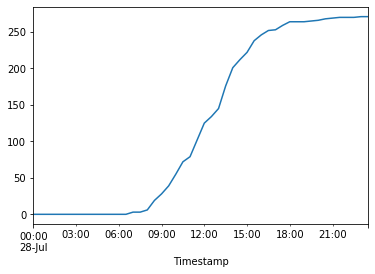

In [430]:
(daily_cumulative(df_pivot)
  .loc['2005-07-28', 'In']
  .plot())

## Resample

In [431]:
def resample_pivot(df_pivot, sampling='h'):
    return (df_pivot
            .resample(sampling)
            .agg({'In':'sum',
                  'Out': 'sum',
                  'Net':'sum',
                  'Date': 'last',
                  'Time': 'first'}))


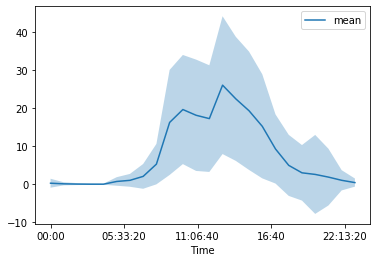

In [432]:
def hourly_with_confidence_bars():
    df_hourly = resample_pivot(df_pivot)
    df_g = (df_hourly
     .groupby('Time')
     .agg({'In':['mean', 'std']}))

    df_g.columns = df_g.columns.get_level_values(1)


    ax = df_g.plot(y='mean')

    ax.fill_between(df_g.index, 
                    df_g['mean']+df_g['std'],
                    df_g['mean']-df_g['std'],
                    alpha=0.3)

hourly_with_confidence_bars()



## By month

In [433]:
def monthly_inflow(monthly):
    
    monthly_in = monthly.loc[:,'In']
    
    monthly_in_groups = monthly_in.reset_index().melt(id_vars='Timestamp').groupby('Timestamp').groups
    monthly_in_melt = monthly_in.reset_index().melt(id_vars='Timestamp')
    monthly_in_melt['Month'] = monthly_in_melt['Timestamp'].dt.month    
    
    
    return monthly_in_melt

In [434]:
montly_in_melt = monthly_inflow(monthly)
monthly_in_melt.head()

,Timestamp,Time,value,Month
0,2005-07-31,00:00:00,0.125000,7
1,2005-08-31,00:00:00,0.548387,8
2,2005-09-30,00:00:00,0.233333,9
3,2005-10-31,00:00:00,0.129032,10
4,2005-11-30,00:00:00,0.000000,11


In [435]:
def month_sparkline(df, max_month='November'):
    
    months = {
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November'}
    
    
    fig, ax = plt.subplots(1,1,figsize=(4,1))
    df.plot(x='Time', y='value', ax=ax, legend=None)

    month = months[df['Month'][0]]


    # remove all the axes
    for k,v in ax.spines.items():
        v.set_visible(False)
    if month is not 'November':
        plt.xlabel('')
    
    
        ax.set_xticks([])
    ax.set_yticks([])
    #plt.axis('off')
    
    plt.ylabel(month, rotation='horizontal', labelpad=40, size=10)
    # remove legend
    
    

""


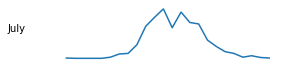

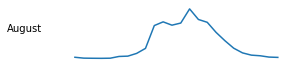

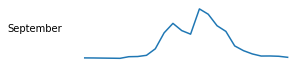

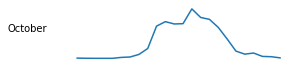

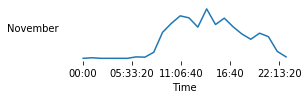

In [436]:
monthly_in_melt.groupby('Month').apply(month_sparkline)

## Day of Week (Sparklines?)

In [ ]:
day_of_week = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}

In [408]:
df_hourly.head()[]

,In,Out,Net,Date,Time
Timestamp,,,,,
2005-07-24 00:00:00,0,1,-1,2005-07-24,00:00:00
2005-07-24 01:00:00,0,0,0,2005-07-24,01:00:00
2005-07-24 02:00:00,0,2,-2,2005-07-24,02:00:00
2005-07-24 03:00:00,0,0,0,2005-07-24,03:00:00
2005-07-24 04:00:00,0,0,0,2005-07-24,04:00:00


In [ ]:
def day_of_week_sparkline(df, max_month='November'):
    
    day_of_week = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
    
    df
    fig, ax = plt.subplots(1,1,figsize=(4,1))
    df.plot(x='Time', y='value', ax=ax, legend=None)

    day = day_of_week[df['Month'][0]]


    # remove all the axes
    for k,v in ax.spines.items():
        v.set_visible(False)
    if month is not 'November':
        plt.xlabel('')
    
    
        ax.set_xticks([])
    ax.set_yticks([])
    #plt.axis('off')
    
    plt.ylabel(month, rotation='horizontal', labelpad=40, size=10)
    # remove legend
    
    